                                time   magnitude   longitude    latitude  \
count                            492  492.000000  492.000000  492.000000   
mean   2023-08-15 07:29:14.622050560    4.800772   24.556356   -0.017742   
min       2023-08-01 02:20:46.066000    4.500000 -179.931400  -62.177500   
25%    2023-08-07 00:07:31.091749888    4.500000  -75.063325  -21.994050   
50%    2023-08-15 00:00:27.827500032    4.700000   70.097650   -1.305250   
75%    2023-08-22 19:23:30.149750016    4.900000  129.117575   21.743200   
max       2023-08-31 21:43:25.888000    7.100000  179.899300   83.475200   
std                              NaN    0.375329  119.982102   29.960864   

            depth  
count  492.000000  
mean    73.788683  
min      2.963000  
25%     10.000000  
50%     25.064500  
75%     71.293500  
max    646.537000  
std    125.042290  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 492 entries, 0 to 491
Data columns (total 6 columns):
 #   Column     Non-Null Count 

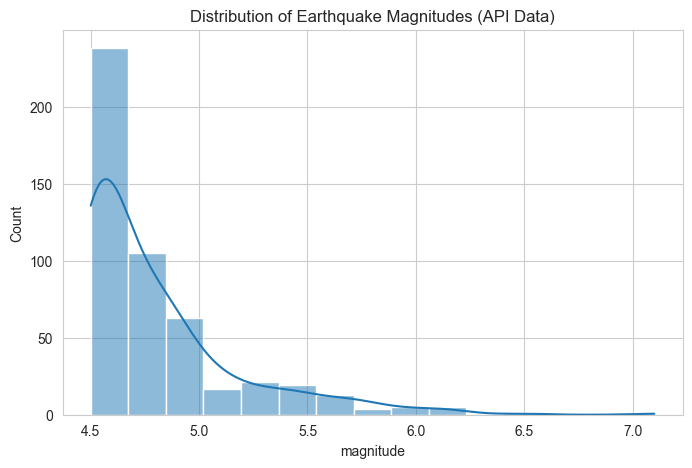

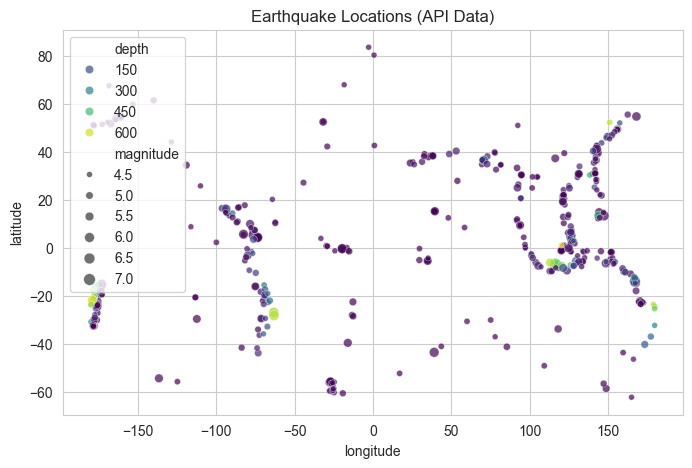

In [10]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fetch earthquake data from USGS API
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
params = {
    "format": "geojson",
    "starttime": "2023-08-01",
    "endtime": "2023-09-01",
    "minmagnitude": 4.5
}
response = requests.get(url, params=params).json()

records = []
for feat in response['features']:
    props = feat['properties']
    geom = feat['geometry']
    records.append({
        "time": pd.to_datetime(props['time'], unit='ms'),
        "place": props['place'],
        "magnitude": props['mag'],
        "longitude": geom['coordinates'][0],
        "latitude": geom['coordinates'][1],
        "depth": geom['coordinates'][2]
    })
df_api = pd.DataFrame(records)

# --- EDA ---
print(df_api.describe())
print(df_api.info())

# --- Visualizations ---
plt.figure(figsize=(8,5))
sns.histplot(df_api['magnitude'], bins=15, kde=True)
plt.title("Distribution of Earthquake Magnitudes (API Data)")
plt.show()

plt.figure(figsize=(8,5))
sns.scatterplot(data=df_api, x="longitude", y="latitude", size="magnitude", hue="depth", alpha=0.7, palette="viridis")
plt.title("Earthquake Locations (API Data)")
plt.show()




Missing values per column before cleaning:
Date         0
Time         0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
Type         0
Status       0
DOMSOI       0
Location     0
dtype: int64

Missing values after imputation:
Date         0
Time         0
Latitude     0
Longitude    0
Depth        0
Magnitude    0
Type         0
Status       0
DOMSOI       0
Location     0
dtype: int64

--- Generating EDA Plots ---


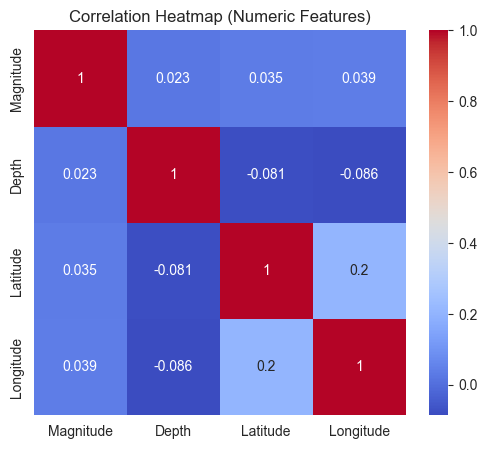

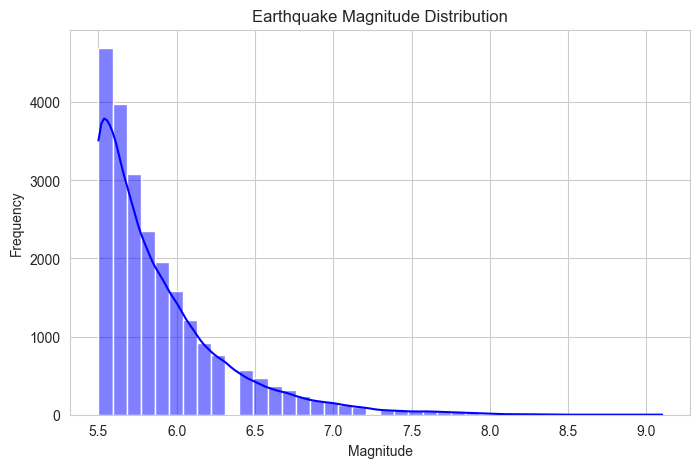

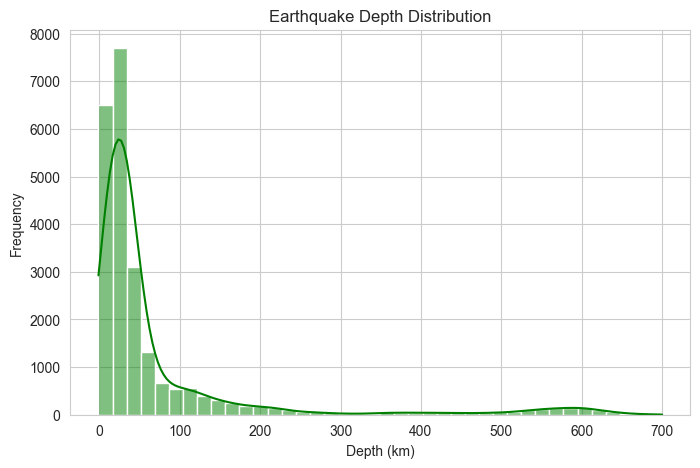

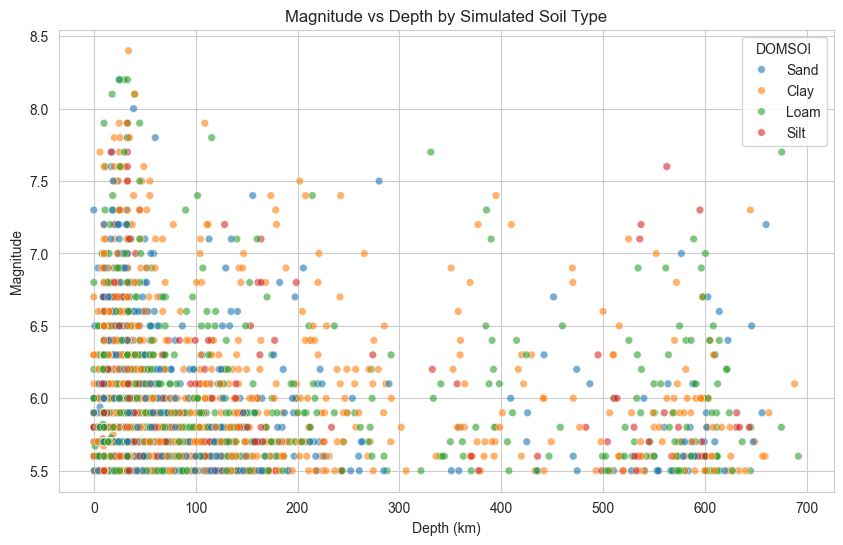

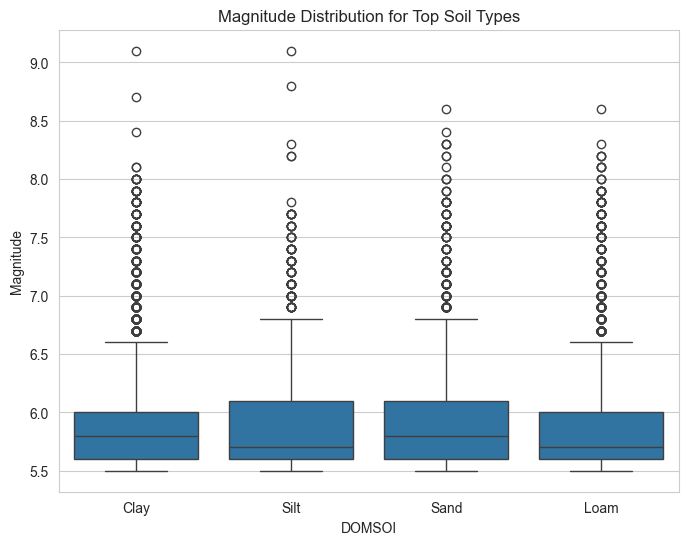


--- Applying Standardization ---
             count          mean       std       min       25%       50%  \
Magnitude  23412.0  5.541821e-16  1.000021 -0.904207 -0.667832 -0.431457   
Depth      23412.0  2.670757e-17  1.000021 -0.585963 -0.458587 -0.307934   
Latitude   23412.0  3.156349e-17  1.000021 -2.615490 -0.675202 -0.174264   
Longitude  23412.0  4.127533e-17  1.000021 -1.749966 -0.924152  0.512648   

                75%       max  
Magnitude  0.277668  7.605293  
Depth     -0.136714  5.130337  
Latitude   0.814004  2.800360  
Longitude  0.839669  1.118308  

--- Applying Label Encoding ---
  DOMSOI  SoilType_Encoded    Location  Location_Encoded
0   Clay                 0  Earthquake                 0
1   Silt                 3  Earthquake                 0
2   Sand                 2  Earthquake                 0
3   Clay                 0  Earthquake                 0
4   Loam                 1  Earthquake                 0

--- Generating Engineered Features ---
  Magnitud

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

FILE_PATH = "C:/Users/THENMOZHI/Downloads/archive/database.csv"
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
df = pd.read_csv(FILE_PATH)
df = df.rename(columns={'mag': 'Magnitude', 'depth': 'Depth'})
df = df[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude', 'Type', 'Status']]

np.random.seed(42)
soil_types = ['Loam', 'Clay', 'Sand', 'Silt']
df['DOMSOI'] = np.random.choice(soil_types, size=len(df), p=[0.3, 0.4, 0.2, 0.1])
df['Location'] = df['Type']

print("Missing values per column before cleaning:")
print(df.isnull().sum())

num_cols = ['Magnitude', 'Depth', 'Latitude', 'Longitude']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

cat_cols = ['Type', 'Status', 'DOMSOI', 'Location']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after imputation:")
print(df.isnull().sum())

print("\n--- Generating EDA Plots ---")

plt.figure(figsize=(6, 5))
sns.heatmap(df[['Magnitude', 'Depth', 'Latitude', 'Longitude']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['Magnitude'], bins=40, kde=True, color="blue")
plt.title("Earthquake Magnitude Distribution")
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['Depth'], bins=40, kde=True, color="green")
plt.title("Earthquake Depth Distribution")
plt.xlabel("Depth (km)")
plt.ylabel("Frequency")
plt.show()

sample_df = df.sample(min(5000, len(df)), random_state=42)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=sample_df,
    x="Depth", y="Magnitude", hue="DOMSOI", alpha=0.6, s=30, legend='full'
)
plt.title("Magnitude vs Depth by Simulated Soil Type")
plt.xlabel("Depth (km)")
plt.ylabel("Magnitude")
plt.show()

top_soils = df['DOMSOI'].value_counts().head(4).index
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=df[df['DOMSOI'].isin(top_soils)],
    x="DOMSOI", y="Magnitude"
)
plt.title("Magnitude Distribution for Top Soil Types")
plt.xticks(rotation=0)
plt.show()

print("\n--- Applying Standardization ---")
numeric_features = ['Magnitude', 'Depth', 'Latitude', 'Longitude']
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])
print(df[numeric_features].describe().T)

print("\n--- Applying Label Encoding ---")
encoder = LabelEncoder()
df['SoilType_Encoded'] = encoder.fit_transform(df['DOMSOI'])

df['Location_Encoded'] = LabelEncoder().fit_transform(df['Location'])
print(df[['DOMSOI', 'SoilType_Encoded', 'Location', 'Location_Encoded']].head())

print("\n--- Generating Engineered Features ---")

df['Magnitude_Class'] = pd.cut(
    df['Magnitude'],
    bins=[-np.inf, 0.5, 1, 1.5, np.inf],
    labels=['Very Low', 'Low', 'Moderate', 'High']
)

df['Depth_Class'] = pd.cut(
    df['Depth'],
    bins=[-np.inf, -0.5, 0.5, np.inf],
    labels=['Shallow', 'Intermediate', 'Deep']
)

df['Risk_Score'] = (
    (df['Magnitude'] * 0.7) +
    (df['Depth'] * 0.3)
)

coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
df['Region_Cluster'] = kmeans.fit_predict(coords)

print(df[['Magnitude_Class', 'Depth_Class', 'Risk_Score', 'Region_Cluster']].head())

df.drop(columns=['Date', 'Time', 'Type', 'Status', 'Location', 'DOMSOI'], inplace=True, errors='ignore')
print(f"\nFinal Feature Set Shape: {df.shape}")
print(f"Final Features: {list(df.columns)}")

FINAL_SAVE_PATH = "C:/Users/THENMOZHI/Downloads/archive/earthquake_final_engineered.csv"
df.to_csv(FINAL_SAVE_PATH, index=False)
print(f"\nFinal engineered dataset saved to: {FINAL_SAVE_PATH}")